In [ ]:
!git clone https://github.com/ece324-2020/FRINN.git

Cloning into 'FRINN'...
remote: Enumerating objects: 17062, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 17062 (delta 50), reused 24 (delta 9), pack-reused 16954
Receiving objects: 100% (17062/17062), 1.96 GiB | 17.97 MiB/s, done.
Resolving deltas: 100% (55/55), done.
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'

^C


In [ ]:
!pip install --upgrade torch torchvision

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import torch.utils.data as data
from torchsummary import summary
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from time import time
import os
import copy


In [ ]:
import os
import torch
import torch.utils.data as data
from typing import Any, Callable, List, Optional, Tuple


class VisionDataset(data.Dataset):
    _repr_indent = 4

    def __init__(
            self,
            root: str,
            transforms: Optional[Callable] = None,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
    ) -> None:
        self.root = root

        has_transforms = transforms is not None
        has_separate_transform = transform is not None or target_transform is not None
        if has_transforms and has_separate_transform:
            raise ValueError("Only transforms or transform/target_transform can "
                             "be passed as argument")

        # for backwards-compatibility
        self.transform = transform
        self.target_transform = target_transform

        if has_separate_transform:
            transforms = StandardTransform(transform, target_transform)
        self.transforms = transforms

    def __getitem__(self, index: int) -> Any:
        raise NotImplementedError

    def __len__(self) -> int:
        raise NotImplementedError

    def __repr__(self) -> str:
        head = "Dataset " + self.__class__.__name__
        body = ["Number of datapoints: {}".format(self.__len__())]
        if self.root is not None:
            body.append("Root location: {}".format(self.root))
        body += self.extra_repr().splitlines()
        if hasattr(self, "transforms") and self.transforms is not None:
            body += [repr(self.transforms)]
        lines = [head] + [" " * self._repr_indent + line for line in body]
        return '\n'.join(lines)

    def _format_transform_repr(self, transform: Callable, head: str) -> List[str]:
        lines = transform.__repr__().splitlines()
        return (["{}{}".format(head, lines[0])] +
                ["{}{}".format(" " * len(head), line) for line in lines[1:]])

    def extra_repr(self) -> str:
        return ""


class StandardTransform(object):
    def __init__(self, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None) -> None:
        self.transform = transform
        self.target_transform = target_transform

    def __call__(self, input: Any, target: Any) -> Tuple[Any, Any]:
        if self.transform is not None:
            input = self.transform(input)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return input, target

    def _format_transform_repr(self, transform: Callable, head: str) -> List[str]:
        lines = transform.__repr__().splitlines()
        return (["{}{}".format(head, lines[0])] +
                ["{}{}".format(" " * len(head), line) for line in lines[1:]])

    def __repr__(self) -> str:
        body = [self.__class__.__name__]
        if self.transform is not None:
            body += self._format_transform_repr(self.transform,
                                                "Transform: ")
        if self.target_transform is not None:
            body += self._format_transform_repr(self.target_transform,
                                                "Target transform: ")

        return '\n'.join(body)

In [ ]:
# Edited Datafolder type and state

from PIL import Image

import os
import os.path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple


def has_file_allowed_extension(filename: str, extensions: Tuple[str, ...]) -> bool:
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
        extensions (tuple of strings): extensions to consider (lowercase)
    Returns:
        bool: True if the filename ends with one of given extensions
    """
    return filename.lower().endswith(extensions)


def is_image_file(filename: str) -> bool:
    """Checks if a file is an allowed image extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)


def make_dataset(
    directory: str,
    class_to_idx: Dict[str, int],
    extensions: Optional[Tuple[str, ...]] = None,
    is_valid_file: Optional[Callable[[str], bool]] = None,
) -> List[Tuple[str, int]]:
    """Generates a list of samples of a form (path_to_sample, class).
    Args:
        directory (str): root dataset directory
        class_to_idx (Dict[str, int]): dictionary mapping class name to class index
        extensions (optional): A list of allowed extensions.
            Either extensions or is_valid_file should be passed. Defaults to None.
        is_valid_file (optional): A function that takes path of a file
            and checks if the file is a valid file
            (used to check of corrupt files) both extensions and
            is_valid_file should not be passed. Defaults to None.
    Raises:
        ValueError: In case ``extensions`` and ``is_valid_file`` are None or both are not None.
    Returns:
        List[Tuple[str, int]]: samples of a form (path_to_sample, class)
    """
    instances = []
    directory = os.path.expanduser(directory)
    both_none = extensions is None and is_valid_file is None
    both_something = extensions is not None and is_valid_file is not None
    if both_none or both_something:
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x: str) -> bool:
            return has_file_allowed_extension(x, cast(Tuple[str, ...], extensions))
    is_valid_file = cast(Callable[[str], bool], is_valid_file)
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = path, class_index
                    instances.append(item)
    return instances


class DatasetFolder_type(VisionDataset):
    """A generic data loader where the samples are arranged in this way: ::
        root/class_x/xxx.ext
        root/class_x/xxy.ext
        root/class_x/xxz.ext
        root/class_y/123.ext
        root/class_y/nsdf3.ext
        root/class_y/asd932_.ext
    Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (tuple[string]): A list of allowed extensions.
            both extensions and is_valid_file should not be passed.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
        is_valid_file (callable, optional): A function that takes path of a file
            and check if the file is a valid file (used to check of corrupt files)
            both extensions and is_valid_file should not be passed.
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        samples (list): List of (sample path, class_index) tuples
        targets (list): The class_index value for each image in the dataset
    """

    def __init__(
            self,
            root: str,
            loader: Callable[[str], Any],
            extensions: Optional[Tuple[str, ...]] = None,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            is_valid_file: Optional[Callable[[str], bool]] = None,
    ) -> None:
        super(DatasetFolder_type, self).__init__(root, transform=transform,
                                            target_transform=target_transform)
        classes, class_to_idx = self._find_classes(self.root)
        samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file)
        if len(samples) == 0:
            msg = "Found 0 files in subfolders of: {}\n".format(self.root)
            if extensions is not None:
                msg += "Supported extensions are: {}".format(",".join(extensions))
            raise RuntimeError(msg)

        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def _find_classes(self, dir: str) -> Tuple[List[str], Dict[str, int]]:
        """
        Finds the class folders in a dataset.
        Args:
            dir (string): Root directory path.
        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.
        Ensures:
            No class is a subdirectory of another.
        """
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        class_to_idx["ri_A"] = 0
        class_to_idx["ri_B"] = 1
        class_to_idx["ri_O"] = 2
        class_to_idx["ri_R"] = 3
        class_to_idx["ri_S"] = 4
        class_to_idx["ro_A"] = 0
        class_to_idx["ro_B"] = 1
        class_to_idx["ro_O"] = 2
        class_to_idx["ro_R"] = 3
        class_to_idx["ro_S"] = 4
        class_to_idx["ur_A"] = 0
        class_to_idx["ur_B"] = 1
        class_to_idx["ur_O"] = 2
        class_to_idx["ur_R"] = 3
        class_to_idx["ur_S"] = 4
        print(class_to_idx)
        return classes, class_to_idx

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)


class DatasetFolder_state(VisionDataset):
    """A generic data loader where the samples are arranged in this way: ::
        root/class_x/xxx.ext
        root/class_x/xxy.ext
        root/class_x/xxz.ext
        root/class_y/123.ext
        root/class_y/nsdf3.ext
        root/class_y/asd932_.ext
    Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (tuple[string]): A list of allowed extensions.
            both extensions and is_valid_file should not be passed.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
        is_valid_file (callable, optional): A function that takes path of a file
            and check if the file is a valid file (used to check of corrupt files)
            both extensions and is_valid_file should not be passed.
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        samples (list): List of (sample path, class_index) tuples
        targets (list): The class_index value for each image in the dataset
    """

    def __init__(
            self,
            root: str,
            loader: Callable[[str], Any],
            extensions: Optional[Tuple[str, ...]] = None,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            is_valid_file: Optional[Callable[[str], bool]] = None,
    ) -> None:
        super(DatasetFolder_state, self).__init__(root, transform=transform,
                                            target_transform=target_transform)
        classes, class_to_idx = self._find_classes(self.root)
        samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file)
        if len(samples) == 0:
            msg = "Found 0 files in subfolders of: {}\n".format(self.root)
            if extensions is not None:
                msg += "Supported extensions are: {}".format(",".join(extensions))
            raise RuntimeError(msg)

        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def _find_classes(self, dir: str) -> Tuple[List[str], Dict[str, int]]:
        """
        Finds the class folders in a dataset.
        Args:
            dir (string): Root directory path.
        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.
        Ensures:
            No class is a subdirectory of another.
        """
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        class_to_idx["ri_A"] = 0
        class_to_idx["ri_B"] = 0
        class_to_idx["ri_O"] = 0
        class_to_idx["ri_R"] = 0
        class_to_idx["ri_S"] = 0
        class_to_idx["ro_A"] = 1
        class_to_idx["ro_B"] = 1
        class_to_idx["ro_O"] = 1
        class_to_idx["ro_R"] = 1
        class_to_idx["ro_S"] = 1
        class_to_idx["ur_A"] = 2
        class_to_idx["ur_B"] = 2
        class_to_idx["ur_O"] = 2
        class_to_idx["ur_R"] = 2
        class_to_idx["ur_S"] = 2

        print(class_to_idx)
        return classes, class_to_idx

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)


IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')


def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


# TODO: specify the return type
def accimage_loader(path: str) -> Any:
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path: str) -> Any:
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)


class ImageFolder_type(DatasetFolder_type):
    """A generic data loader where the images are arranged in this way: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(
            self,
            root: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            loader: Callable[[str], Any] = default_loader,
            is_valid_file: Optional[Callable[[str], bool]] = None,
    ):
        super(ImageFolder_type, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        self.imgs = self.samples

class ImageFolder_state(DatasetFolder_state):
    """A generic data loader where the images are arranged in this way: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(
            self,
            root: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            loader: Callable[[str], Any] = default_loader,
            is_valid_file: Optional[Callable[[str], bool]] = None,
    ):
        super(ImageFolder_state, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        self.imgs = self.samples

In [ ]:
# Transform before mean and standard deviation
my_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.ToPILImage(),
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean = [0.66445047,0.55465436,0.447036], std = [0.321551,0.33547384,0.3524585])
  ])


In [ ]:
# Dataloader for state and type
dataset_type = ImageFolder_type(root='/content/FRINN/Data_FRINN', transform=my_transform)
dataset_state = ImageFolder_state(root='/content/FRINN/Data_FRINN', transform=my_transform)
dataloader_type = DataLoader(dataset_type, batch_size=10,shuffle=True, num_workers=2)
dataloader_state = DataLoader(dataset_state, batch_size=10,shuffle=True, num_workers=2)


In [ ]:
print(len(dataset_state))
train_data, valid_data, test_data = torch.utils.data.random_split(dataset_state, [9600,2400,4954], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64,shuffle=True)
test_loader = DataLoader(test_data, batch_size=64,shuffle=True)

#test_white =  torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/ECE324 project/test_white_bg', transform=my_transform)
#test_varied =  torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/ECE324 project/test_varied_bg', transform=my_transform)

#test_white_loader = DataLoader(test_white, batch_size=8)
#test_varied_loader = DataLoader(test_varied, batch_size=8)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
from torchvision import models
from torch import nn
vgg = models.vgg16_bn(pretrained=True)
for param in vgg.features.parameters():
    param.requires_grad = False

In [ ]:
class MyVgg(nn.Module):
    def __init__(self,originalmodel):
        super(MyVgg,self).__init__()
        vgg = originalmodel
        # Here you get the bottleneck/feature extractor
        self.vgg_feature_extractor = nn.Sequential(*list(vgg.children())[:-1])

        self.classifier1 = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 3),
            nn.Sigmoid()
        )
        self.classifier2 = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 5),
            nn.Sigmoid()
                            )

    # Set your own forward pass
    def forward(self, img, extra_info=None):

        x = self.vgg_feature_extractor(img)
        x = x.view(x.size(0), -1)
        x1 = self.classifier1(x)
        x2 = self.classifier2(x)

        return x1, x2

In [ ]:
lr = 0.03
epochs = 20
eval_every = 5
model = MyVgg(vgg)
model.to(device)
my_optim = torch.optim.SGD(model.parameters(), lr=lr)
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=decayRate)
loss_fnc= torch.nn.CrossEntropyLoss()
#loss_fnc= torch.nn.MSELoss()
loss_fnc.to(device)
batch_size = 64



#OUTPUT DATA ARGUMENTS
seed = 1
torch.manual_seed(seed)
save= True
confusion=True
plot = True
statistics = True

In [ ]:
def relabel_state(argument): # ripe rotten unripe
    switcher = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 1,
        6: 1,
        7: 1,
        8: 1,
        9: 1,
        10:2,
        11:2,
        12:2,
        13:2,
        14:2}
    return switcher[argument.item()]

def relabel_type(argument): # Apple Banana Orange Strawberry Raspberry
    switcher = {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 0,
        6: 1,
        7: 2,
        8: 3,
        9: 4,
        10:0,
        11:1,
        12:2,
        13:3,
        14:4}
    return switcher[argument.item()]

In [ ]:
def relabel_state_oh(argument):
    switcher = {
        0: [1.0, 0.0, 0.0],
        1: [1.0, 0.0, 0.0],
        2: [1.0, 0.0, 0.0],
        3: [1.0, 0.0, 0.0],
        4: [1.0, 0.0, 0.0],
        5: [0.0, 1.0, 0.0],
        6: [0.0, 1.0, 0.0],
        7: [0.0, 1.0, 0.0],
        8: [0.0, 1.0, 0.0],
        9: [0.0, 1.0, 0.0],
        10:[0.0, 0.0, 1.0],
        11:[0.0, 0.0, 1.0],
        12:[0.0, 0.0, 1.0],
        13:[0.0, 0.0, 1.0],
        14:[0.0, 0.0, 1.0]}
    return switcher[argument]

def relabel_type_oh(argument):
    switcher = {
        0: [1.0, 0.0, 0.0, 0.0, 0.0],
        1: [0.0, 1.0, 0.0, 0.0, 0.0],
        2: [0.0, 0.0, 1.0, 0.0, 0.0],
        3: [0.0, 0.0, 0.0, 1.0, 0.0],
        4: [0.0, 0.0, 0.0, 0.0, 1.0],
        5: [1.0, 0.0, 0.0, 0.0, 0.0],
        6: [0.0, 1.0, 0.0, 0.0, 0.0],
        7: [0.0, 0.0, 1.0, 0.0, 0.0],
        8: [0.0, 0.0, 0.0, 1.0, 0.0],
        9: [0.0, 0.0, 0.0, 0.0, 1.0],
        10:[1.0, 0.0, 0.0, 0.0, 0.0],
        11:[0.0, 1.0, 0.0, 0.0, 0.0],
        12:[0.0, 0.0, 1.0, 0.0, 0.0],
        13:[0.0, 0.0, 0.0, 1.0, 0.0],
        14:[0.0, 0.0, 0.0, 0.0, 1.0]}
    return switcher[argument]

In [ ]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=1, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# ***Training section***

In [ ]:
train_loss_list = []
train_acc_list = []
train_loss_list_state = []
train_acc_list_state = []
train_loss_list_type = []
train_acc_list_type = []

valid_loss_list = []
valid_acc_list = []
valid_loss_list_state = []
valid_acc_list_state = []
valid_loss_list_type = []
valid_acc_list_type = []

epoch_list = []         #Epoch number
start = time()

for e in range(epochs):
    model.train()
    print("Time:    ", time() - start)
    running_loss = []
    running_accuracy = []
    running_loss_state = []
    running_accuracy_state = []
    running_loss_type = []
    running_accuracy_type = []

    running_valid_loss = []
    running_valid_accuracy = []
    running_valid_loss_state = []
    running_valid_accuracy_state = []
    running_valid_loss_type = []
    running_valid_accuracy_type = []

  #               LOOKING AT TRAINING DATA

    for i, data in enumerate(train_loader):

            #get batch of data
        inputs, label = data[0].to(device), data[1].to(device)

        label_state = torch.zeros(len(label)).to(device)
        label_type = torch.zeros(len(label)).to(device)

        for k in range(len(label)):
          label_state[k] = relabel_state(label[k])
          label_type[k] = relabel_type(label[k])


        # Setting gradients to zero and running model on batch
        my_optim.zero_grad()
        predictions_state, predictions_type = model(inputs)

        # Computing loss based on Cross Entropy
        batch_loss_state = loss_fnc(input=predictions_state.squeeze(), target=label_state.long())
        batch_loss_type = loss_fnc(input=predictions_type.squeeze(), target=label_type.long())

        # Combining losses and calculating gradients
        Overall_loss = batch_loss_state + batch_loss_type
        Overall_loss.backward()
        my_optim.step()
        # Evaluating Training Acc
        _, predicted_state = torch.max(predictions_state.data, 1)
        _,predicted_type = torch.max(predictions_type.data, 1)

        trainAcc_state = (label_state == predicted_state).sum().item() / 64
        trainAcc_type = (label_type == predicted_type).sum().item() / 64

        if i % eval_every == 0:
           print("epoch: {} {} |||   loss type:   {}  trainAcc type:   {} |||  loss state {}  trainAcc state:  {}  ".format(e+1,i, batch_loss_type, trainAcc_type, batch_loss_state, trainAcc_state))

        running_loss.append(Overall_loss.item())
        running_accuracy.append((trainAcc_state+trainAcc_type)/2)
        running_loss_state.append(batch_loss_state.item())
        running_accuracy_state.append(trainAcc_state)
        running_loss_type.append(batch_loss_type.item())
        running_accuracy_type.append(trainAcc_type)

        del Overall_loss
        del batch_loss_state
        del batch_loss_type
        del label_state
        del label_type
        del predictions_state
        del predictions_type

    for j, data in enumerate(valid_loader):
        model.eval()
            #get batch of data
        inputs, label = data[0].to(device), data[1].to(device)

        vlabel_state = torch.zeros(len(label)).to(device)
        vlabel_type = torch.zeros(len(label)).to(device)

        for k in range(len(label)):
          vlabel_state[k] = relabel_state(label[k])
          vlabel_type[k] = relabel_type(label[k])

          #run model on validation batch
        predictions_state_v, predictions_type_v = model(inputs)

            #compute loss
        batch_valid_loss_state = loss_fnc(input=predictions_state_v.squeeze(), target=vlabel_state.long())
        batch_valid_loss_type = loss_fnc(input=predictions_type_v.squeeze(), target=vlabel_type.long())

        Overall_loss_v = batch_valid_loss_state.float() + batch_valid_loss_type.float()

            #evaluate
        _, predicted_state_v = torch.max(predictions_state_v.data, 1)
        _,predicted_type_v = torch.max(predictions_type_v.data, 1)

        validAcc_state = (vlabel_state == predicted_state_v).sum().item() / 64
        validAcc_type = (vlabel_type == predicted_type_v).sum().item() / 64

        if j % eval_every == 0:
             print("epoch: {} |||   vloss type:   {}  validAcc type:   {} |||  vloss state {}  validAcc state:  {}  ".format(e+1, batch_valid_loss_type, validAcc_type, batch_valid_loss_state,validAcc_state))

        running_valid_loss.append(Overall_loss_v.item())
        running_valid_accuracy.append((validAcc_state+validAcc_type)/2)
        running_valid_loss_state.append(batch_valid_loss_state.item())
        running_valid_accuracy_state.append(validAcc_state)
        running_valid_loss_type.append(batch_valid_loss_type.item())
        running_valid_accuracy_type.append(validAcc_type)

        del Overall_loss_v
        del batch_valid_loss_state
        del batch_valid_loss_type
        del vlabel_state
        del vlabel_type
        del predictions_state_v
        del predictions_type_v

    #Overall accuracy
    trainacc_ = sum(running_accuracy) / float(len(running_accuracy))
    train_acc_list.append(trainacc_)
    #state accuracy
    trainacc_state_ = sum(running_accuracy_state) / float(len(running_accuracy_state))
    train_acc_list_state.append(trainacc_state_)
    #type accuracy
    trainAcc_type_ = sum(running_accuracy_type) / float(len(running_accuracy_type))
    train_acc_list_type.append(trainAcc_type_)

    #             lists for TRAINING losses
    #Overall Loss
    loss_ = sum(running_loss) / float(len(running_loss))
    train_loss_list.append(loss_)
    #State Loss
    loss_state_ = sum(running_loss_state) / float(len(running_loss_state))
    train_loss_list_state.append(loss_state_)
    #Type Loss
    loss_type_ = sum(running_loss_type) / float(len(running_loss_type))
    train_loss_list_type.append(loss_type_)

    #------------------------------------------------------------------------------------
    #             lists for VALIDATION accuracy
    #Overall accuracy
    validacc_ = sum(running_valid_accuracy) / float(len(running_valid_accuracy))
    valid_acc_list.append(validacc_)
    #state accuracy
    validacc_state_ = sum(running_valid_accuracy_state) / float(len(running_valid_accuracy_state))
    valid_acc_list_state.append(validacc_state_)
    #type accuracy
    validAcc_type_ = sum(running_valid_accuracy_type) / float(len(running_valid_accuracy_type))
    valid_acc_list_type.append(validAcc_type_)

    #             lists for VALIDATION losses
    #Overall Loss
    valid_loss_ = sum(running_valid_loss) / float(len(running_valid_loss))
    valid_loss_list.append(valid_loss_)
    #State Loss
    valid_loss_state_ = sum(running_valid_loss_state) / float(len(running_valid_loss_state))
    valid_loss_list_state.append(valid_loss_state_)
    #Type Loss
    valid_loss_type_ = sum(running_valid_loss_type) / float(len(running_valid_loss_type))
    valid_loss_list_type.append(valid_loss_type_)

    a=EarlyStopping(valid_loss_, model)

    if a.early_stop == True:
        print("Early stopping")
        break


Time:     0.0016214847564697266
epoch: 1 0 |||   loss type:   0.9092447757720947  trainAcc type:   1.0 |||  loss state 0.5514994859695435  trainAcc state:  1.0  
epoch: 1 5 |||   loss type:   0.9147443771362305  trainAcc type:   1.0 |||  loss state 0.551688551902771  trainAcc state:  1.0  
epoch: 1 10 |||   loss type:   0.9270826578140259  trainAcc type:   0.984375 |||  loss state 0.5515194535255432  trainAcc state:  1.0  
epoch: 1 15 |||   loss type:   0.914254903793335  trainAcc type:   1.0 |||  loss state 0.5515127778053284  trainAcc state:  1.0  
epoch: 1 20 |||   loss type:   0.9281913042068481  trainAcc type:   1.0 |||  loss state 0.551578938961029  trainAcc state:  1.0  
epoch: 1 25 |||   loss type:   0.9149776101112366  trainAcc type:   0.984375 |||  loss state 0.5515867471694946  trainAcc state:  1.0  
epoch: 1 30 |||   loss type:   0.919753909111023  trainAcc type:   1.0 |||  loss state 0.5515098571777344  trainAcc state:  1.0  
epoch: 1 35 |||   loss type:   0.90984028577804

In [ ]:
torch.save(model.state_dict(), "fruit_model.pt")

In [ ]:
print("Max train Acc: ", max(train_acc_list))
print("Max valid Acc: ", max(valid_acc_list))

Max train Acc:  0.9894791666666667
Max valid Acc:  0.9730674342105263


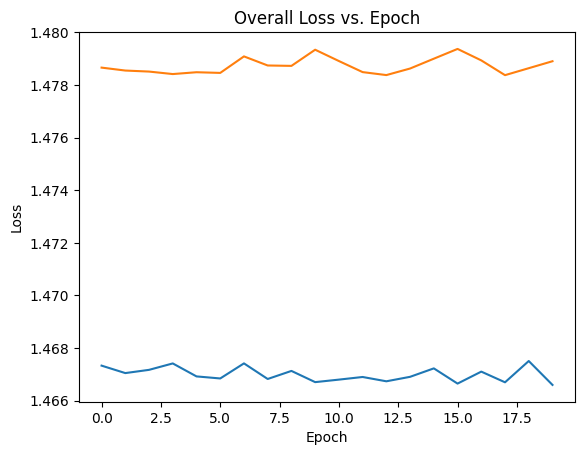

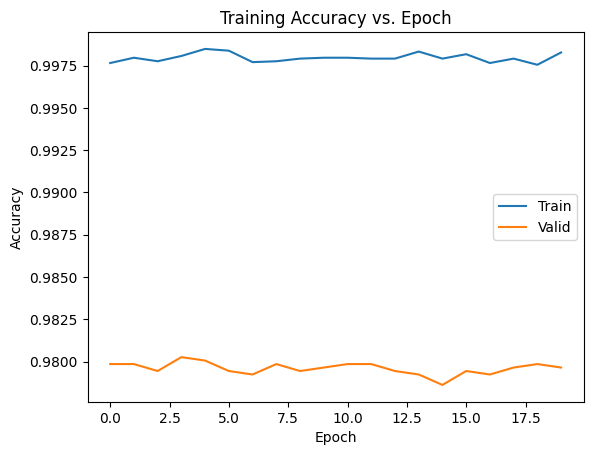

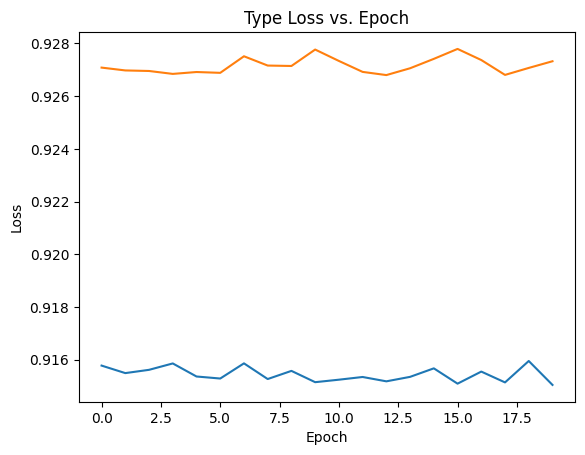

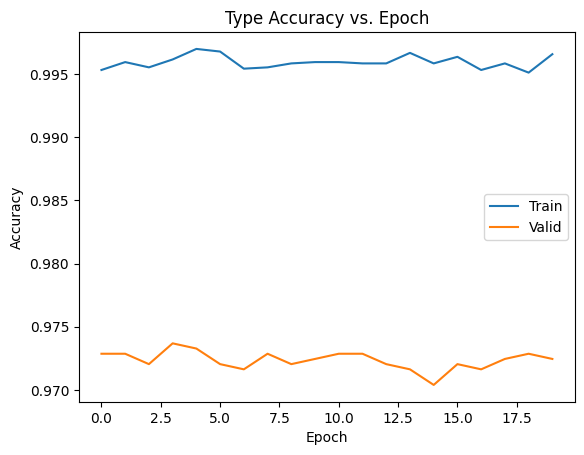

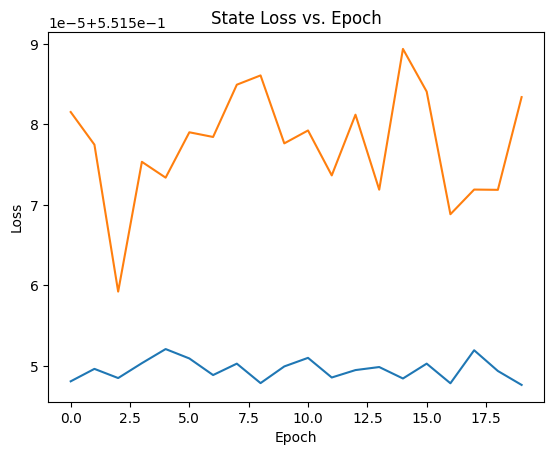

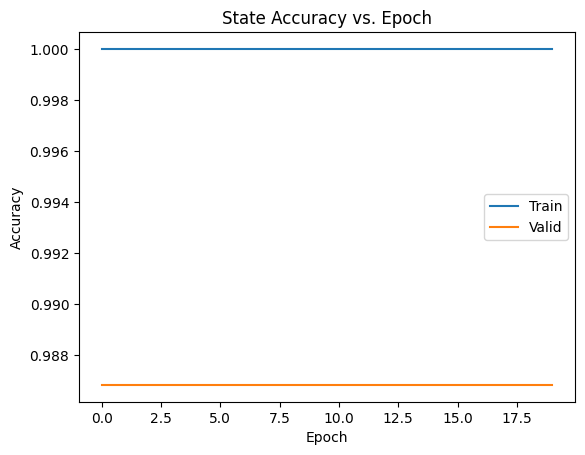

<Figure size 640x480 with 0 Axes>

In [ ]:
if plot == True:
        epoch_num = range(20)
        #Plot overall loss vs epoch
        plt.plot(epoch_num, train_loss_list, label='Train')
        plt.plot(epoch_num, valid_loss_list, label='Valid')
        plt.title('Overall Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        plt.savefig('overall_loss')

        #Plot overall Accuracy vs epoch
        plt.plot(epoch_num, train_acc_list, label='Train')
        plt.plot(epoch_num, valid_acc_list, label='Valid')
        plt.title('Training Accuracy vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.savefig('train_acc')

                #Plot TYPE loss vs epoch
        plt.plot(epoch_num, train_loss_list_type, label='Train')
        plt.plot(epoch_num, valid_loss_list_type, label='Valid')
        plt.title('Type Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        plt.savefig('type_loss')

                #Plot TYPE Accuracy vs epoch
        plt.plot(epoch_num, train_acc_list_type, label='Train')
        plt.plot(epoch_num, valid_acc_list_type, label='Valid')
        plt.title('Type Accuracy vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.savefig('type_acc')

                #Plot STATE loss vs epoch
        plt.plot(epoch_num, train_loss_list_state, label='Train')
        plt.plot(epoch_num, valid_loss_list_state, label='Valid')
        plt.title('State Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        plt.savefig('state_loss')

                #Plot STATE Accuracy vs epoch
        plt.plot(epoch_num, train_acc_list_state, label='Train')
        plt.plot(epoch_num, valid_acc_list_state, label='Valid')
        plt.title('State Accuracy vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.savefig('state_acc')


In [ ]:
def recombine_prediction(argument1,argument2):
    switcher = {
         str([0,0]): 0,
         str([0,1]): 1,
         str([0,2]): 2,
         str([0,3]): 3,
         str([0,4]): 4,
         str([1,0]): 5,
         str([1,1]): 6,
         str([1,2]): 7,
         str([1,3]): 8,
         str([1,4]): 9,
         str([2,0]):10,
         str([2,1]):11,
         str([2,2]):12,
         str([2,3]):13,
         str([2,4]):14}
    return switcher[str([argument1.item(),argument2.item()])]

In [ ]:
from sklearn.metrics import confusion_matrix
# Initialize the prediction and label lists(tensors)
predlist_state=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist_state=torch.zeros(0,dtype=torch.long, device='cpu')
predlist_type=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist_type=torch.zeros(0,dtype=torch.long, device='cpu')
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')


with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs, label = data[0].to(device), data[1].to(device)
        vlabel_state = torch.zeros(len(label)).to(device)
        vlabel_type = torch.zeros(len(label)).to(device)
        for k in range(len(label)):
            vlabel_state[k] = relabel_state(label[k])
            vlabel_type[k] = relabel_type(label[k])


        predictions_state_v, predictions_type_v = model(inputs)
        _, predicted_state_v = torch.max(predictions_state_v.data, 1)
        _,predicted_type_v = torch.max(predictions_type_v.data, 1)

        # Append batch prediction results
        predlist_state=torch.cat([predlist_state,predicted_state_v.view(-1).cpu()])
        lbllist_state=torch.cat([lbllist_state,vlabel_state.view(-1).cpu()])
        predlist_type=torch.cat([predlist_type,predicted_type_v.view(-1).cpu()])
        lbllist_type=torch.cat([lbllist_type,vlabel_type.view(-1).cpu()])

        predicted = torch.zeros(len(label)).to(device)
        # 15 label confusion matrix
        for k in range(len(predicted_state_v)):
            predicted[k] = recombine_prediction(predicted_state_v[k],predicted_type_v[k])
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])







# Confusion matrix
conf_mat_state=confusion_matrix(lbllist_state.numpy(), predlist_state.numpy())
conf_mat_type=confusion_matrix(lbllist_type.numpy(), predlist_type.numpy())
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print("Confusion Matrix:")
print(conf_mat)
print("State Confusion Matrix")
print(conf_mat_state)
print("Type Confusion Matrix")
print(conf_mat_type)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print("Class Accuracy")
print(class_accuracy)
class_accuracy_state=100*conf_mat_state.diagonal()/conf_mat_state.sum(1)
print("State Accuracy")
print(class_accuracy_state)
class_accuracy_type=100*conf_mat_type.diagonal()/conf_mat_type.sum(1)
print("Type Accuracy")
print(class_accuracy_type)

Confusion Matrix:
[[768  16   3]
 [ 12 771   2]
 [  2   0 826]]
State Confusion Matrix
[[2400]]
Type Confusion Matrix
[[768  16   3]
 [ 12 771   2]
 [  2   0 826]]
Class Accuracy
[97.58576874 98.21656051 99.75845411]
State Accuracy
[100.]
Type Accuracy
[97.58576874 98.21656051 99.75845411]


In [ ]:
!cp /content/fruit_model.pt /content/drive/MyDrive/fruit_saved_weight

cp: cannot create regular file '/content/drive/MyDrive/fruit_saved_weight': No such file or directory


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Confusion matrix and classification report
conf_mat_state=confusion_matrix(lbllist_state.numpy(), predlist_state.numpy())
conf_mat_type=confusion_matrix(lbllist_type.numpy(), predlist_type.numpy())
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
class_report_state = classification_report(lbllist_state.numpy(), predlist_state.numpy())
class_report_type = classification_report(lbllist_type.numpy(), predlist_type.numpy())
class_report = classification_report(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print(conf_mat_state)
print(conf_mat_type)
print("State class report:")
print(class_report_state)
print("Type class report:")
print(class_report_type)
print("Class report")
print(class_report)

[[768  16   3]
 [ 12 771   2]
 [  2   0 826]]
[[2400]]
[[768  16   3]
 [ 12 771   2]
 [  2   0 826]]
State class report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2400

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

Type class report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       787
         1.0       0.98      0.98      0.98       785
         2.0       0.99      1.00      1.00       828

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400

Class report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       787
           1       0.98      0.98      0.98       785
           2       0.99      1

# ***Testing Section***

In [ ]:
import cv2
from skimage import io
from PIL import Image
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = Image.open('/content/FRINN/Data_FRINN/ri_S/ri_s-gb-0.png')
image = np.array(image)
my_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.ToPILImage(),
  transforms.Resize((224,224)),
  transforms.ToTensor()
  ])
image = my_transform(image[0:,0:,0:3])
image_cuda_tensor  =  torch.Tensor(image).float().to(device)
image_cuda_tensor = image_cuda_tensor.resize(1,image_cuda_tensor.shape[0],image_cuda_tensor.shape[1],image_cuda_tensor.shape[2])
model = MyVgg(vgg)
model.load_state_dict(torch.load('/content/fruit_model.pt'))
model.to(device)
predictions_state_v, predictions_type_v= model(image_cuda_tensor)
_, predicted_state_v = torch.max(predictions_state_v.data, 1)
_,predicted_type_v = torch.max(predictions_type_v.data, 1)
print("Predicted state for the fruit" , predictions_state_v)
print("Predicted type for the fruit" , predictions_type_v)
if torch.argmax(predictions_state_v) == 0:
  print("The state is ripe")
if torch.argmax(predictions_state_v) == 1:
  print("The state is Rotten")
if torch.argmax(predictions_state_v) == 2:
  print("The state is Unripe")
predlist_state=torch.cat([predlist_state,predicted_state_v.view(-1).cpu()])
lbllist_state=torch.cat([lbllist_state,vlabel_state.view(-1).cpu()])
predlist_type=torch.cat([predlist_type,predicted_type_v.view(-1).cpu()])
lbllist_type=torch.cat([lbllist_type,vlabel_type.view(-1).cpu()])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,